In [1]:
cd ..

E:\18-09-19 Document structure\business\Study\Master\Cognitive Computing\P3\Machine learning in practice\git\Private\M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    
                    validation_data=(X_val, y_val))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 2s 9ms/sample - loss: 1.1917 - val_loss: 0.9042
Epoch 2/300
269/269 [==============================] - 0s 749us/sample - loss: 0.8217 - val_loss: 0.7791
Epoch 3/300
269/269 [==============================] - 0s 119us/sample - loss: 0.7792 - val_loss: 0.6893
Epoch 4/300
269/269 [==============================] - 0s 115us/sample - loss: 0.7038 - val_loss: 0.6442
Epoch 5/300
269/269 [==============================] - 0s 113us/sample - loss: 0.6833 - val_loss: 0.6131
Epoch 6/300
269/269 [==============================] - 0s 130us/sample - loss: 0.6547 - val_loss: 0.5905
Epoch 7/300
269/269 [==============================] - 0s 123us/sample - loss: 0.6272 - val_loss: 0.5632
Epoch 8/300
269/269 [==============================] - 0s 117us/sample - loss: 0.5996 - val_loss: 0.5338
Epoch 9/300
269/269 [==============================] - 0s 119us/sample - loss: 0.5675 - val_loss: 0.5071
Epoch 10/300

Epoch 78/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0263 - val_loss: 0.0323
Epoch 79/300
269/269 [==============================] - 0s 110us/sample - loss: 0.0273 - val_loss: 0.0194
Epoch 80/300
269/269 [==============================] - 0s 117us/sample - loss: 0.0203 - val_loss: 0.0301
Epoch 81/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0232 - val_loss: 0.0166
Epoch 82/300
269/269 [==============================] - 0s 110us/sample - loss: 0.0190 - val_loss: 0.0257
Epoch 83/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0274 - val_loss: 0.0208
Epoch 84/300
269/269 [==============================] - 0s 101us/sample - loss: 0.0262 - val_loss: 0.0208
Epoch 85/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0415 - val_loss: 0.0457
Epoch 86/300
269/269 [==============================] - ETA: 0s - loss: 0.043 - 0s 102us/sample - loss: 0.0291 - val_loss: 0.0365
Epoch 87/300
269/269 [

269/269 [==============================] - 0s 119us/sample - loss: 0.0123 - val_loss: 0.0132
Epoch 155/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0145 - val_loss: 0.0216
Epoch 156/300
269/269 [==============================] - 0s 117us/sample - loss: 0.0167 - val_loss: 0.0154
Epoch 157/300
269/269 [==============================] - 0s 119us/sample - loss: 0.0131 - val_loss: 0.0112
Epoch 158/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0139 - val_loss: 0.0137
Epoch 159/300
269/269 [==============================] - 0s 121us/sample - loss: 0.0134 - val_loss: 0.0105
Epoch 160/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0124 - val_loss: 0.0274
Epoch 161/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0253 - val_loss: 0.0303
Epoch 162/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0203 - val_loss: 0.0225
Epoch 163/300
269/269 [============================

269/269 [==============================] - 0s 110us/sample - loss: 0.0151 - val_loss: 0.0136
Epoch 231/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0167 - val_loss: 0.0172
Epoch 232/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0143 - val_loss: 0.0146
Epoch 233/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0124 - val_loss: 0.0111
Epoch 234/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0126 - val_loss: 0.0199
Epoch 235/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0220 - val_loss: 0.0207
Epoch 236/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0143 - val_loss: 0.0137
Epoch 237/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0172 - val_loss: 0.0183
Epoch 238/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0199 - val_loss: 0.0189
Epoch 239/300
269/269 [============================

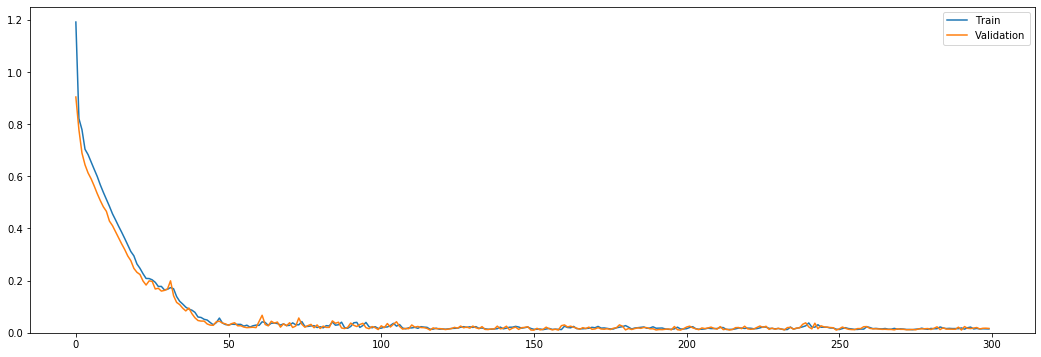

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.4114417 , 0.48735207, 0.61332107, 0.6514602 , 0.7352706 ,
        0.82840574, 0.8609055 , 0.9938454 , 1.0638919 ],
       [0.8470335 , 1.0021744 , 1.2437438 , 1.3201789 , 1.4834784 ,
        1.6747763 , 1.7289132 , 2.0042746 , 2.1307094 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [34]:
# Assumes the following order of statistical distribution parameters for
# the neurons in the layer before this custom layer:
# x[0] = mu
# x[1] = sigma
# x[2] = skewness
# x[3] = kurtosis
def DistributionLayer(quantile_index,x):
    mu = x[0]
    sigma = x[1] 
    skewness = None
    kurtosis = None
    
    # absorb extra statistical distribution parameters if present
    if (len(x.get_shape().as_list())>2):
        skewness= x[2]
    if (len(x.get_shape().as_list())>3):
        kurtosis = x[3]
        
    if (skewness==None):
        if (kurtosis==None):
            # Source of Z-scores: https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
             return {
                0.005: mu-2.57583*sigma, # https://www.wolframalpha.com/input/?i=0.5+percentiles+of+a+normal+distribution
                0.025: mu-1.95996*sigma, # https://www.wolframalpha.com/input/?i=2.5+percentiles+of+a+normal+distribution
                0.165: mu-0.974114*sigma, # https://www.wolframalpha.com/input/?i=16.5+percentiles+of+a+normal+distribution
                0.25: mu-0.674*sigma, # https://www.wolframalpha.com/input/?i=25+percentiles+of+a+normal+distribution
                0.5: mu, # https://www.wolframalpha.com/input/?i=50+percentiles+of+a+normal+distribution
                0.75: mu+0.674*sigma, # https://www.wolframalpha.com/input/?i=75+percentiles+of+a+normal+distribution
                0.835: mu+0.9741114*sigma, #https://www.wolframalpha.com/input/?i=83.5+percentiles+of+a+normal+distribution
                0.975: mu+1.95996*sigma, #https://www.wolframalpha.com/input/?i=97.5+percentiles+of+a+normal+distribution
                0.995: mu+2.57583*sigma, #https://www.wolframalpha.com/input/?i=99.5+percentiles+of+a+normal+distribution
            }[quantile]
    

In [44]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q2 = Dense(1, name="q2")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q3 = Dense(1, name="q3")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q4 = Dense(1, name="q4")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q5 = Dense(1, name="q5")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q6 = Dense(1, name="q6")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q7 = Dense(1, name="q7")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q8 = Dense(1, name="q8")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    
#     out_q0 = DistributionLayer(quantiles[0],x)
#     out_q1 = DistributionLayer(quantiles[1],x)
#     out_q2 = DistributionLayer(quantiles[2],x)
#     out_q3 = DistributionLayer(quantiles[3],x)
#     out_q4 = DistributionLayer(quantiles[4],x)
#     out_q5 = DistributionLayer(quantiles[5],x)
#     out_q6 = DistributionLayer(quantiles[6],x)
#     out_q7 = DistributionLayer(quantiles[7],x)
#     out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [45]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [46]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [47]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 8s 30ms/sample - loss: 9.3887 - q0_loss: 0.3492 - q1_loss: 1.2614 - q2_loss: 0.8594 - q3_loss: 0.7702 - q4_loss: 1.7556 - q5_loss: 0.9433 - q6_loss: 1.3629 - q7_loss: 1.0075 - q8_loss: 0.9800 - val_loss: 7.7223 - val_q0_loss: 0.2429 - val_q1_loss: 0.6034 - val_q2_loss: 0.7927 - val_q3_loss: 0.3369 - val_q4_loss: 2.3526 - val_q5_loss: 0.4498 - val_q6_loss: 1.4083 - val_q7_loss: 0.4748 - val_q8_loss: 0.7471
Epoch 2/300
269/269 [==============================] - 0s 909us/sample - loss: 7.7623 - q0_loss: 0.3139 - q1_loss: 0.4869 - q2_loss: 0.8207 - q3_loss: 0.5435 - q4_loss: 1.8904 - q5_loss: 0.6724 - q6_loss: 1.5193 - q7_loss: 0.8002 - q8_loss: 0.7495 - val_loss: 6.9800 - val_q0_loss: 0.2315 - val_q1_loss: 0.4347 - val_q2_loss: 0.7173 - val_q3_loss: 0.4473 - val_q4_loss: 1.6614 - val_q5_loss: 0.5546 - val_q6_loss: 1.3188 - val_q7_loss: 0.6444 - val_q8_loss: 0.4899
Epoch 3/300
269/269 [=====

269/269 [==============================] - 0s 199us/sample - loss: 4.1618 - q0_loss: 0.0481 - q1_loss: 0.0965 - q2_loss: 0.4700 - q3_loss: 0.0790 - q4_loss: 1.8472 - q5_loss: 0.1004 - q6_loss: 1.2631 - q7_loss: 0.1208 - q8_loss: 0.1130 - val_loss: 3.9532 - val_q0_loss: 0.0610 - val_q1_loss: 0.1489 - val_q2_loss: 0.4294 - val_q3_loss: 0.0874 - val_q4_loss: 1.4993 - val_q5_loss: 0.1253 - val_q6_loss: 1.0112 - val_q7_loss: 0.1751 - val_q8_loss: 0.2201
Epoch 19/300
269/269 [==============================] - 0s 195us/sample - loss: 4.1765 - q0_loss: 0.0430 - q1_loss: 0.1634 - q2_loss: 0.4565 - q3_loss: 0.0970 - q4_loss: 1.8247 - q5_loss: 0.1200 - q6_loss: 1.2271 - q7_loss: 0.1345 - q8_loss: 0.0944 - val_loss: 3.7307 - val_q0_loss: 0.0338 - val_q1_loss: 0.2525 - val_q2_loss: 0.4198 - val_q3_loss: 0.0183 - val_q4_loss: 1.5903 - val_q5_loss: 0.0192 - val_q6_loss: 0.9263 - val_q7_loss: 0.0485 - val_q8_loss: 0.2036
Epoch 20/300
269/269 [==============================] - 0s 199us/sample - loss: 3

Epoch 36/300
269/269 [==============================] - 0s 180us/sample - loss: 2.7759 - q0_loss: 0.0391 - q1_loss: 0.0359 - q2_loss: 0.1073 - q3_loss: 0.0690 - q4_loss: 1.4465 - q5_loss: 0.0856 - q6_loss: 0.8225 - q7_loss: 0.0917 - q8_loss: 0.0697 - val_loss: 2.4291 - val_q0_loss: 0.0230 - val_q1_loss: 0.0423 - val_q2_loss: 0.0836 - val_q3_loss: 0.0336 - val_q4_loss: 1.1854 - val_q5_loss: 0.0505 - val_q6_loss: 0.6765 - val_q7_loss: 0.0561 - val_q8_loss: 0.1050
Epoch 37/300
269/269 [==============================] - 0s 169us/sample - loss: 2.5534 - q0_loss: 0.0249 - q1_loss: 0.0305 - q2_loss: 0.0993 - q3_loss: 0.0291 - q4_loss: 1.4099 - q5_loss: 0.0355 - q6_loss: 0.8088 - q7_loss: 0.0418 - q8_loss: 0.0661 - val_loss: 2.3759 - val_q0_loss: 0.0332 - val_q1_loss: 0.0346 - val_q2_loss: 0.0531 - val_q3_loss: 0.0506 - val_q4_loss: 1.2477 - val_q5_loss: 0.0542 - val_q6_loss: 0.6496 - val_q7_loss: 0.0652 - val_q8_loss: 0.0333
Epoch 38/300
269/269 [==============================] - 0s 173us/sam

Epoch 54/300
269/269 [==============================] - 0s 182us/sample - loss: 2.0937 - q0_loss: 0.0471 - q1_loss: 0.0912 - q2_loss: 0.0956 - q3_loss: 0.0717 - q4_loss: 1.0652 - q5_loss: 0.0900 - q6_loss: 0.4023 - q7_loss: 0.1047 - q8_loss: 0.1244 - val_loss: 1.8314 - val_q0_loss: 0.0403 - val_q1_loss: 0.1003 - val_q2_loss: 0.0579 - val_q3_loss: 0.0546 - val_q4_loss: 0.8388 - val_q5_loss: 0.0771 - val_q6_loss: 0.2880 - val_q7_loss: 0.0897 - val_q8_loss: 0.1640
Epoch 55/300
269/269 [==============================] - 0s 186us/sample - loss: 1.8549 - q0_loss: 0.0268 - q1_loss: 0.0787 - q2_loss: 0.0772 - q3_loss: 0.0469 - q4_loss: 1.0485 - q5_loss: 0.0574 - q6_loss: 0.3711 - q7_loss: 0.0610 - q8_loss: 0.0700 - val_loss: 1.6594 - val_q0_loss: 0.0303 - val_q1_loss: 0.0251 - val_q2_loss: 0.0524 - val_q3_loss: 0.0500 - val_q4_loss: 0.8177 - val_q5_loss: 0.0699 - val_q6_loss: 0.3042 - val_q7_loss: 0.0741 - val_q8_loss: 0.0893
Epoch 56/300
269/269 [==============================] - 0s 184us/sam

Epoch 72/300
269/269 [==============================] - 0s 191us/sample - loss: 1.1810 - q0_loss: 0.0278 - q1_loss: 0.0201 - q2_loss: 0.0661 - q3_loss: 0.0366 - q4_loss: 0.6836 - q5_loss: 0.0463 - q6_loss: 0.1730 - q7_loss: 0.0518 - q8_loss: 0.0501 - val_loss: 1.1947 - val_q0_loss: 0.0448 - val_q1_loss: 0.0507 - val_q2_loss: 0.0656 - val_q3_loss: 0.0521 - val_q4_loss: 0.5584 - val_q5_loss: 0.0613 - val_q6_loss: 0.1192 - val_q7_loss: 0.0758 - val_q8_loss: 0.0825
Epoch 73/300
269/269 [==============================] - 0s 191us/sample - loss: 1.2567 - q0_loss: 0.0340 - q1_loss: 0.0324 - q2_loss: 0.0738 - q3_loss: 0.0492 - q4_loss: 0.6852 - q5_loss: 0.0631 - q6_loss: 0.1870 - q7_loss: 0.0726 - q8_loss: 0.0711 - val_loss: 0.9674 - val_q0_loss: 0.0170 - val_q1_loss: 0.0453 - val_q2_loss: 0.0333 - val_q3_loss: 0.0194 - val_q4_loss: 0.5210 - val_q5_loss: 0.0273 - val_q6_loss: 0.1112 - val_q7_loss: 0.0286 - val_q8_loss: 0.0492
Epoch 74/300
269/269 [==============================] - 0s 204us/sam

Epoch 90/300
269/269 [==============================] - 0s 171us/sample - loss: 0.6908 - q0_loss: 0.0218 - q1_loss: 0.0184 - q2_loss: 0.0487 - q3_loss: 0.0221 - q4_loss: 0.3253 - q5_loss: 0.0306 - q6_loss: 0.1596 - q7_loss: 0.0354 - q8_loss: 0.0423 - val_loss: 0.6262 - val_q0_loss: 0.0220 - val_q1_loss: 0.0158 - val_q2_loss: 0.0280 - val_q3_loss: 0.0348 - val_q4_loss: 0.1723 - val_q5_loss: 0.0494 - val_q6_loss: 0.0892 - val_q7_loss: 0.0534 - val_q8_loss: 0.0550
Epoch 91/300
269/269 [==============================] - 0s 177us/sample - loss: 0.6843 - q0_loss: 0.0219 - q1_loss: 0.0228 - q2_loss: 0.0501 - q3_loss: 0.0244 - q4_loss: 0.2868 - q5_loss: 0.0303 - q6_loss: 0.1568 - q7_loss: 0.0364 - q8_loss: 0.0357 - val_loss: 0.5006 - val_q0_loss: 0.0206 - val_q1_loss: 0.0147 - val_q2_loss: 0.0414 - val_q3_loss: 0.0155 - val_q4_loss: 0.1650 - val_q5_loss: 0.0150 - val_q6_loss: 0.1068 - val_q7_loss: 0.0203 - val_q8_loss: 0.0186
Epoch 92/300
269/269 [==============================] - 0s 178us/sam

Epoch 108/300
269/269 [==============================] - 0s 186us/sample - loss: 0.6591 - q0_loss: 0.0242 - q1_loss: 0.0290 - q2_loss: 0.0338 - q3_loss: 0.0341 - q4_loss: 0.2624 - q5_loss: 0.0435 - q6_loss: 0.1505 - q7_loss: 0.0493 - q8_loss: 0.0446 - val_loss: 0.5336 - val_q0_loss: 0.0200 - val_q1_loss: 0.0401 - val_q2_loss: 0.0233 - val_q3_loss: 0.0309 - val_q4_loss: 0.1454 - val_q5_loss: 0.0417 - val_q6_loss: 0.0889 - val_q7_loss: 0.0440 - val_q8_loss: 0.0193
Epoch 109/300
269/269 [==============================] - 0s 242us/sample - loss: 0.6318 - q0_loss: 0.0219 - q1_loss: 0.0294 - q2_loss: 0.0310 - q3_loss: 0.0316 - q4_loss: 0.2607 - q5_loss: 0.0402 - q6_loss: 0.1557 - q7_loss: 0.0425 - q8_loss: 0.0292 - val_loss: 0.4591 - val_q0_loss: 0.0220 - val_q1_loss: 0.0248 - val_q2_loss: 0.0304 - val_q3_loss: 0.0159 - val_q4_loss: 0.1377 - val_q5_loss: 0.0198 - val_q6_loss: 0.0901 - val_q7_loss: 0.0223 - val_q8_loss: 0.0235
Epoch 110/300
269/269 [==============================] - 0s 180us/

Epoch 126/300
269/269 [==============================] - 0s 173us/sample - loss: 0.5350 - q0_loss: 0.0220 - q1_loss: 0.0238 - q2_loss: 0.0169 - q3_loss: 0.0185 - q4_loss: 0.2319 - q5_loss: 0.0242 - q6_loss: 0.1248 - q7_loss: 0.0277 - q8_loss: 0.0339 - val_loss: 0.4039 - val_q0_loss: 0.0170 - val_q1_loss: 0.0265 - val_q2_loss: 0.0135 - val_q3_loss: 0.0124 - val_q4_loss: 0.1325 - val_q5_loss: 0.0209 - val_q6_loss: 0.0747 - val_q7_loss: 0.0207 - val_q8_loss: 0.0194
Epoch 127/300
269/269 [==============================] - 0s 173us/sample - loss: 0.5149 - q0_loss: 0.0193 - q1_loss: 0.0243 - q2_loss: 0.0167 - q3_loss: 0.0150 - q4_loss: 0.2420 - q5_loss: 0.0201 - q6_loss: 0.1300 - q7_loss: 0.0239 - q8_loss: 0.0289 - val_loss: 0.5404 - val_q0_loss: 0.0271 - val_q1_loss: 0.0529 - val_q2_loss: 0.0340 - val_q3_loss: 0.0254 - val_q4_loss: 0.1328 - val_q5_loss: 0.0306 - val_q6_loss: 0.0821 - val_q7_loss: 0.0399 - val_q8_loss: 0.0583
Epoch 128/300
269/269 [==============================] - 0s 179us/

Epoch 144/300
269/269 [==============================] - 0s 178us/sample - loss: 0.5155 - q0_loss: 0.0221 - q1_loss: 0.0223 - q2_loss: 0.0169 - q3_loss: 0.0211 - q4_loss: 0.2222 - q5_loss: 0.0269 - q6_loss: 0.1119 - q7_loss: 0.0322 - q8_loss: 0.0334 - val_loss: 0.6045 - val_q0_loss: 0.0363 - val_q1_loss: 0.0326 - val_q2_loss: 0.0403 - val_q3_loss: 0.0446 - val_q4_loss: 0.1200 - val_q5_loss: 0.0529 - val_q6_loss: 0.1025 - val_q7_loss: 0.0633 - val_q8_loss: 0.0692
Epoch 145/300
269/269 [==============================] - 0s 182us/sample - loss: 0.6073 - q0_loss: 0.0290 - q1_loss: 0.0279 - q2_loss: 0.0300 - q3_loss: 0.0335 - q4_loss: 0.2253 - q5_loss: 0.0417 - q6_loss: 0.1145 - q7_loss: 0.0514 - q8_loss: 0.0555 - val_loss: 0.4084 - val_q0_loss: 0.0191 - val_q1_loss: 0.0299 - val_q2_loss: 0.0118 - val_q3_loss: 0.0150 - val_q4_loss: 0.1207 - val_q5_loss: 0.0166 - val_q6_loss: 0.0855 - val_q7_loss: 0.0201 - val_q8_loss: 0.0240
Epoch 146/300
269/269 [==============================] - 0s 199us/

Epoch 162/300
269/269 [==============================] - 0s 186us/sample - loss: 0.4242 - q0_loss: 0.0198 - q1_loss: 0.0173 - q2_loss: 0.0115 - q3_loss: 0.0126 - q4_loss: 0.2042 - q5_loss: 0.0155 - q6_loss: 0.0851 - q7_loss: 0.0208 - q8_loss: 0.0274 - val_loss: 0.3363 - val_q0_loss: 0.0189 - val_q1_loss: 0.0164 - val_q2_loss: 0.0080 - val_q3_loss: 0.0119 - val_q4_loss: 0.1139 - val_q5_loss: 0.0143 - val_q6_loss: 0.0606 - val_q7_loss: 0.0190 - val_q8_loss: 0.0190
Epoch 163/300
269/269 [==============================] - 0s 193us/sample - loss: 0.4040 - q0_loss: 0.0187 - q1_loss: 0.0144 - q2_loss: 0.0087 - q3_loss: 0.0110 - q4_loss: 0.2099 - q5_loss: 0.0132 - q6_loss: 0.0848 - q7_loss: 0.0172 - q8_loss: 0.0230 - val_loss: 0.3462 - val_q0_loss: 0.0197 - val_q1_loss: 0.0311 - val_q2_loss: 0.0120 - val_q3_loss: 0.0081 - val_q4_loss: 0.1140 - val_q5_loss: 0.0092 - val_q6_loss: 0.0572 - val_q7_loss: 0.0120 - val_q8_loss: 0.0312
Epoch 164/300
269/269 [==============================] - 0s 180us/

Epoch 180/300
269/269 [==============================] - 0s 183us/sample - loss: 0.4712 - q0_loss: 0.0237 - q1_loss: 0.0146 - q2_loss: 0.0217 - q3_loss: 0.0280 - q4_loss: 0.1946 - q5_loss: 0.0347 - q6_loss: 0.0672 - q7_loss: 0.0413 - q8_loss: 0.0384 - val_loss: 0.4047 - val_q0_loss: 0.0250 - val_q1_loss: 0.0148 - val_q2_loss: 0.0211 - val_q3_loss: 0.0290 - val_q4_loss: 0.1044 - val_q5_loss: 0.0326 - val_q6_loss: 0.0739 - val_q7_loss: 0.0398 - val_q8_loss: 0.0366
Epoch 181/300
269/269 [==============================] - 0s 193us/sample - loss: 0.4265 - q0_loss: 0.0214 - q1_loss: 0.0239 - q2_loss: 0.0173 - q3_loss: 0.0178 - q4_loss: 0.1945 - q5_loss: 0.0220 - q6_loss: 0.0623 - q7_loss: 0.0291 - q8_loss: 0.0357 - val_loss: 0.4153 - val_q0_loss: 0.0174 - val_q1_loss: 0.0298 - val_q2_loss: 0.0152 - val_q3_loss: 0.0361 - val_q4_loss: 0.1092 - val_q5_loss: 0.0472 - val_q6_loss: 0.0403 - val_q7_loss: 0.0513 - val_q8_loss: 0.0208
Epoch 182/300
269/269 [==============================] - 0s 221us/

Epoch 198/300
269/269 [==============================] - 0s 197us/sample - loss: 0.3810 - q0_loss: 0.0205 - q1_loss: 0.0264 - q2_loss: 0.0165 - q3_loss: 0.0177 - q4_loss: 0.1687 - q5_loss: 0.0224 - q6_loss: 0.0370 - q7_loss: 0.0292 - q8_loss: 0.0369 - val_loss: 0.3185 - val_q0_loss: 0.0174 - val_q1_loss: 0.0337 - val_q2_loss: 0.0155 - val_q3_loss: 0.0073 - val_q4_loss: 0.0958 - val_q5_loss: 0.0093 - val_q6_loss: 0.0386 - val_q7_loss: 0.0140 - val_q8_loss: 0.0324
Epoch 199/300
269/269 [==============================] - 0s 188us/sample - loss: 0.4680 - q0_loss: 0.0245 - q1_loss: 0.0264 - q2_loss: 0.0192 - q3_loss: 0.0371 - q4_loss: 0.1729 - q5_loss: 0.0454 - q6_loss: 0.0649 - q7_loss: 0.0507 - q8_loss: 0.0326 - val_loss: 0.4599 - val_q0_loss: 0.0187 - val_q1_loss: 0.0381 - val_q2_loss: 0.0193 - val_q3_loss: 0.0471 - val_q4_loss: 0.0998 - val_q5_loss: 0.0586 - val_q6_loss: 0.0519 - val_q7_loss: 0.0656 - val_q8_loss: 0.0221
Epoch 200/300
269/269 [==============================] - 0s 188us/

Epoch 216/300
269/269 [==============================] - 0s 201us/sample - loss: 0.3427 - q0_loss: 0.0210 - q1_loss: 0.0277 - q2_loss: 0.0120 - q3_loss: 0.0173 - q4_loss: 0.1600 - q5_loss: 0.0211 - q6_loss: 0.0302 - q7_loss: 0.0255 - q8_loss: 0.0290 - val_loss: 0.2462 - val_q0_loss: 0.0166 - val_q1_loss: 0.0183 - val_q2_loss: 0.0075 - val_q3_loss: 0.0105 - val_q4_loss: 0.0835 - val_q5_loss: 0.0137 - val_q6_loss: 0.0208 - val_q7_loss: 0.0161 - val_q8_loss: 0.0204
Epoch 217/300
269/269 [==============================] - 0s 193us/sample - loss: 0.2979 - q0_loss: 0.0186 - q1_loss: 0.0190 - q2_loss: 0.0092 - q3_loss: 0.0124 - q4_loss: 0.1513 - q5_loss: 0.0146 - q6_loss: 0.0257 - q7_loss: 0.0197 - q8_loss: 0.0247 - val_loss: 0.2227 - val_q0_loss: 0.0177 - val_q1_loss: 0.0135 - val_q2_loss: 0.0073 - val_q3_loss: 0.0073 - val_q4_loss: 0.0837 - val_q5_loss: 0.0079 - val_q6_loss: 0.0217 - val_q7_loss: 0.0117 - val_q8_loss: 0.0165
Epoch 218/300
269/269 [==============================] - 0s 203us/

Epoch 234/300
269/269 [==============================] - 0s 195us/sample - loss: 0.3444 - q0_loss: 0.0230 - q1_loss: 0.0207 - q2_loss: 0.0167 - q3_loss: 0.0244 - q4_loss: 0.1281 - q5_loss: 0.0294 - q6_loss: 0.0351 - q7_loss: 0.0355 - q8_loss: 0.0319 - val_loss: 0.4912 - val_q0_loss: 0.0249 - val_q1_loss: 0.0253 - val_q2_loss: 0.0285 - val_q3_loss: 0.0518 - val_q4_loss: 0.0734 - val_q5_loss: 0.0655 - val_q6_loss: 0.0736 - val_q7_loss: 0.0722 - val_q8_loss: 0.0378
Epoch 235/300
269/269 [==============================] - 0s 195us/sample - loss: 0.5230 - q0_loss: 0.0304 - q1_loss: 0.0289 - q2_loss: 0.0288 - q3_loss: 0.0499 - q4_loss: 0.1307 - q5_loss: 0.0618 - q6_loss: 0.0759 - q7_loss: 0.0698 - q8_loss: 0.0448 - val_loss: 0.6186 - val_q0_loss: 0.0387 - val_q1_loss: 0.0366 - val_q2_loss: 0.0331 - val_q3_loss: 0.0719 - val_q4_loss: 0.0746 - val_q5_loss: 0.0868 - val_q6_loss: 0.1132 - val_q7_loss: 0.0949 - val_q8_loss: 0.0445
Epoch 236/300
269/269 [==============================] - 0s 194us/

Epoch 252/300
269/269 [==============================] - 0s 186us/sample - loss: 0.2674 - q0_loss: 0.0195 - q1_loss: 0.0308 - q2_loss: 0.0131 - q3_loss: 0.0124 - q4_loss: 0.1051 - q5_loss: 0.0140 - q6_loss: 0.0185 - q7_loss: 0.0183 - q8_loss: 0.0328 - val_loss: 0.2402 - val_q0_loss: 0.0203 - val_q1_loss: 0.0353 - val_q2_loss: 0.0150 - val_q3_loss: 0.0098 - val_q4_loss: 0.0707 - val_q5_loss: 0.0114 - val_q6_loss: 0.0126 - val_q7_loss: 0.0152 - val_q8_loss: 0.0359
Epoch 253/300
269/269 [==============================] - 0s 182us/sample - loss: 0.3516 - q0_loss: 0.0209 - q1_loss: 0.0529 - q2_loss: 0.0127 - q3_loss: 0.0236 - q4_loss: 0.1087 - q5_loss: 0.0289 - q6_loss: 0.0397 - q7_loss: 0.0326 - q8_loss: 0.0360 - val_loss: 0.2341 - val_q0_loss: 0.0203 - val_q1_loss: 0.0163 - val_q2_loss: 0.0097 - val_q3_loss: 0.0166 - val_q4_loss: 0.0653 - val_q5_loss: 0.0193 - val_q6_loss: 0.0245 - val_q7_loss: 0.0220 - val_q8_loss: 0.0236
Epoch 254/300
269/269 [==============================] - 0s 195us/

Epoch 270/300
269/269 [==============================] - 0s 173us/sample - loss: 0.2570 - q0_loss: 0.0199 - q1_loss: 0.0202 - q2_loss: 0.0104 - q3_loss: 0.0201 - q4_loss: 0.0832 - q5_loss: 0.0240 - q6_loss: 0.0312 - q7_loss: 0.0270 - q8_loss: 0.0221 - val_loss: 0.3023 - val_q0_loss: 0.0187 - val_q1_loss: 0.0178 - val_q2_loss: 0.0154 - val_q3_loss: 0.0310 - val_q4_loss: 0.0445 - val_q5_loss: 0.0402 - val_q6_loss: 0.0463 - val_q7_loss: 0.0433 - val_q8_loss: 0.0220
Epoch 271/300
269/269 [==============================] - 0s 190us/sample - loss: 0.3023 - q0_loss: 0.0227 - q1_loss: 0.0267 - q2_loss: 0.0170 - q3_loss: 0.0244 - q4_loss: 0.0817 - q5_loss: 0.0293 - q6_loss: 0.0362 - q7_loss: 0.0342 - q8_loss: 0.0324 - val_loss: 0.3016 - val_q0_loss: 0.0190 - val_q1_loss: 0.0387 - val_q2_loss: 0.0252 - val_q3_loss: 0.0193 - val_q4_loss: 0.0506 - val_q5_loss: 0.0256 - val_q6_loss: 0.0199 - val_q7_loss: 0.0309 - val_q8_loss: 0.0450
Epoch 272/300
269/269 [==============================] - 0s 184us/

Epoch 288/300
269/269 [==============================] - 0s 193us/sample - loss: 0.3378 - q0_loss: 0.0277 - q1_loss: 0.0135 - q2_loss: 0.0252 - q3_loss: 0.0372 - q4_loss: 0.0591 - q5_loss: 0.0463 - q6_loss: 0.0537 - q7_loss: 0.0522 - q8_loss: 0.0398 - val_loss: 0.2815 - val_q0_loss: 0.0226 - val_q1_loss: 0.0219 - val_q2_loss: 0.0130 - val_q3_loss: 0.0316 - val_q4_loss: 0.0381 - val_q5_loss: 0.0377 - val_q6_loss: 0.0506 - val_q7_loss: 0.0396 - val_q8_loss: 0.0224
Epoch 289/300
269/269 [==============================] - 0s 199us/sample - loss: 0.4033 - q0_loss: 0.0283 - q1_loss: 0.0271 - q2_loss: 0.0291 - q3_loss: 0.0409 - q4_loss: 0.0584 - q5_loss: 0.0514 - q6_loss: 0.0595 - q7_loss: 0.0583 - q8_loss: 0.0496 - val_loss: 0.1759 - val_q0_loss: 0.0175 - val_q1_loss: 0.0203 - val_q2_loss: 0.0078 - val_q3_loss: 0.0117 - val_q4_loss: 0.0338 - val_q5_loss: 0.0158 - val_q6_loss: 0.0173 - val_q7_loss: 0.0192 - val_q8_loss: 0.0204
Epoch 290/300
269/269 [==============================] - 0s 201us/

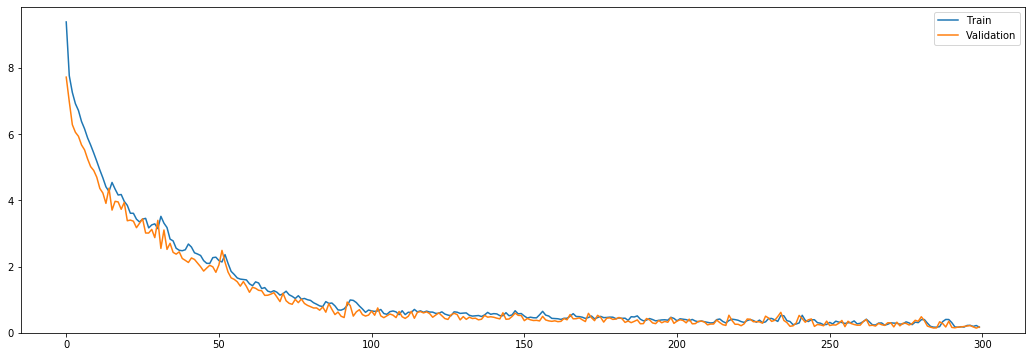

In [48]:
plot_loss(history)

In [49]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.4055748 , 0.47743964, 0.60120326, 0.6377    , 0.74691874,
        0.8046563 , 0.8431643 , 0.9648038 , 1.0393609 ],
       [0.85474133, 1.025546  , 1.2492846 , 1.3207661 , 1.4387442 ,
        1.6559818 , 1.7261361 , 1.9803336 , 2.1380525 ]], dtype=float32)

**Note**: training seems slower! 

## Employ pinball loss

In [50]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [51]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

In [52]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [53]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 12ms/sample - loss: 7.0769 - q0_loss: 0.8913 - q1_loss: 0.3594 - q2_loss: 0.2427 - q3_loss: 0.9209 - q4_loss: 0.9328 - q5_loss: 0.5843 - q6_loss: 0.5614 - q7_loss: 1.6276 - q8_loss: 0.7763 - val_loss: 4.1472 - val_q0_loss: 0.0193 - val_q1_loss: 0.0166 - val_q2_loss: 0.1467 - val_q3_loss: 2.2790 - val_q4_loss: 1.2020 - val_q5_loss: 0.2534 - val_q6_loss: 0.1728 - val_q7_loss: 0.2249 - val_q8_loss: 0.0736
Epoch 2/300
269/269 [==============================] - 0s 201us/sample - loss: 4.1032 - q0_loss: 0.0188 - q1_loss: 0.0203 - q2_loss: 0.1641 - q3_loss: 2.0511 - q4_loss: 1.0213 - q5_loss: 0.1994 - q6_loss: 0.1688 - q7_loss: 0.3025 - q8_loss: 0.1106 - val_loss: 2.7499 - val_q0_loss: 0.0118 - val_q1_loss: 0.0349 - val_q2_loss: 0.1239 - val_q3_loss: 1.0181 - val_q4_loss: 0.7105 - val_q5_loss: 0.2546 - val_q6_loss: 0.1864 - val_q7_loss: 0.5118 - val_q8_loss: 0.0831
Epoch 3/300
269/269 [=====

269/269 [==============================] - 0s 212us/sample - loss: 1.0141 - q0_loss: 0.0076 - q1_loss: 0.0084 - q2_loss: 0.1259 - q3_loss: 0.0309 - q4_loss: 0.0488 - q5_loss: 0.0396 - q6_loss: 0.0336 - q7_loss: 0.7026 - q8_loss: 0.0163 - val_loss: 0.9046 - val_q0_loss: 0.0070 - val_q1_loss: 0.0072 - val_q2_loss: 0.1075 - val_q3_loss: 0.0487 - val_q4_loss: 0.0544 - val_q5_loss: 0.0244 - val_q6_loss: 0.0221 - val_q7_loss: 0.5711 - val_q8_loss: 9.1811e-04
Epoch 19/300
269/269 [==============================] - 0s 221us/sample - loss: 0.9483 - q0_loss: 0.0077 - q1_loss: 0.0089 - q2_loss: 0.1213 - q3_loss: 0.0328 - q4_loss: 0.0385 - q5_loss: 0.0274 - q6_loss: 0.0233 - q7_loss: 0.6792 - q8_loss: 0.0111 - val_loss: 0.9073 - val_q0_loss: 0.0070 - val_q1_loss: 0.0067 - val_q2_loss: 0.1070 - val_q3_loss: 0.0481 - val_q4_loss: 0.0619 - val_q5_loss: 0.0351 - val_q6_loss: 0.0302 - val_q7_loss: 0.5496 - val_q8_loss: 0.0012
Epoch 20/300
269/269 [==============================] - 0s 225us/sample - los

Epoch 36/300
269/269 [==============================] - 0s 232us/sample - loss: 0.3520 - q0_loss: 0.0091 - q1_loss: 0.0108 - q2_loss: 0.0514 - q3_loss: 0.0497 - q4_loss: 0.0207 - q5_loss: 0.0117 - q6_loss: 0.0103 - q7_loss: 0.1947 - q8_loss: 9.1429e-04 - val_loss: 0.3254 - val_q0_loss: 0.0082 - val_q1_loss: 0.0109 - val_q2_loss: 0.0298 - val_q3_loss: 0.0375 - val_q4_loss: 0.0188 - val_q5_loss: 0.0473 - val_q6_loss: 0.0472 - val_q7_loss: 0.0928 - val_q8_loss: 0.0024
Epoch 37/300
269/269 [==============================] - 0s 216us/sample - loss: 0.3160 - q0_loss: 0.0089 - q1_loss: 0.0104 - q2_loss: 0.0476 - q3_loss: 0.0195 - q4_loss: 0.0142 - q5_loss: 0.0218 - q6_loss: 0.0201 - q7_loss: 0.1670 - q8_loss: 0.0013 - val_loss: 0.2219 - val_q0_loss: 0.0083 - val_q1_loss: 0.0102 - val_q2_loss: 0.0286 - val_q3_loss: 0.0350 - val_q4_loss: 0.0070 - val_q5_loss: 0.0100 - val_q6_loss: 0.0083 - val_q7_loss: 0.0749 - val_q8_loss: 5.7857e-04
Epoch 38/300
269/269 [==============================] - 0s 2

269/269 [==============================] - 0s 284us/sample - loss: 0.1473 - q0_loss: 0.0096 - q1_loss: 0.0096 - q2_loss: 0.0274 - q3_loss: 0.0135 - q4_loss: 0.0148 - q5_loss: 0.0134 - q6_loss: 0.0121 - q7_loss: 0.0431 - q8_loss: 9.0938e-04 - val_loss: 0.1224 - val_q0_loss: 0.0086 - val_q1_loss: 0.0091 - val_q2_loss: 0.0143 - val_q3_loss: 0.0125 - val_q4_loss: 0.0254 - val_q5_loss: 0.0136 - val_q6_loss: 0.0082 - val_q7_loss: 0.0228 - val_q8_loss: 6.5733e-04
Epoch 54/300
269/269 [==============================] - 0s 234us/sample - loss: 0.1473 - q0_loss: 0.0098 - q1_loss: 0.0098 - q2_loss: 0.0279 - q3_loss: 0.0193 - q4_loss: 0.0186 - q5_loss: 0.0140 - q6_loss: 0.0120 - q7_loss: 0.0351 - q8_loss: 9.0581e-04 - val_loss: 0.1719 - val_q0_loss: 0.0087 - val_q1_loss: 0.0097 - val_q2_loss: 0.0238 - val_q3_loss: 0.0096 - val_q4_loss: 0.0284 - val_q5_loss: 0.0342 - val_q6_loss: 0.0281 - val_q7_loss: 0.0212 - val_q8_loss: 4.6519e-04
Epoch 55/300
269/269 [==============================] - 0s 256us/

269/269 [==============================] - 0s 203us/sample - loss: 0.1543 - q0_loss: 0.0097 - q1_loss: 0.0074 - q2_loss: 0.0369 - q3_loss: 0.0250 - q4_loss: 0.0135 - q5_loss: 0.0268 - q6_loss: 0.0231 - q7_loss: 0.0112 - q8_loss: 0.0012 - val_loss: 0.1472 - val_q0_loss: 0.0090 - val_q1_loss: 0.0055 - val_q2_loss: 0.0228 - val_q3_loss: 0.0214 - val_q4_loss: 0.0155 - val_q5_loss: 0.0310 - val_q6_loss: 0.0254 - val_q7_loss: 0.0081 - val_q8_loss: 0.0015
Epoch 71/300
269/269 [==============================] - 0s 195us/sample - loss: 0.1553 - q0_loss: 0.0099 - q1_loss: 0.0071 - q2_loss: 0.0344 - q3_loss: 0.0178 - q4_loss: 0.0211 - q5_loss: 0.0306 - q6_loss: 0.0255 - q7_loss: 0.0079 - q8_loss: 0.0014 - val_loss: 0.1720 - val_q0_loss: 0.0089 - val_q1_loss: 0.0078 - val_q2_loss: 0.0219 - val_q3_loss: 0.0083 - val_q4_loss: 0.0305 - val_q5_loss: 0.0465 - val_q6_loss: 0.0449 - val_q7_loss: 0.0077 - val_q8_loss: 0.0023
Epoch 72/300
269/269 [==============================] - 0s 212us/sample - loss: 0

Epoch 88/300
269/269 [==============================] - 0s 206us/sample - loss: 0.1613 - q0_loss: 0.0099 - q1_loss: 0.0045 - q2_loss: 0.0295 - q3_loss: 0.0190 - q4_loss: 0.0351 - q5_loss: 0.0328 - q6_loss: 0.0259 - q7_loss: 0.0072 - q8_loss: 0.0014 - val_loss: 0.1501 - val_q0_loss: 0.0087 - val_q1_loss: 0.0088 - val_q2_loss: 0.0223 - val_q3_loss: 0.0178 - val_q4_loss: 0.0135 - val_q5_loss: 0.0360 - val_q6_loss: 0.0306 - val_q7_loss: 0.0083 - val_q8_loss: 0.0017
Epoch 89/300
269/269 [==============================] - 0s 194us/sample - loss: 0.1433 - q0_loss: 0.0097 - q1_loss: 0.0048 - q2_loss: 0.0305 - q3_loss: 0.0159 - q4_loss: 0.0214 - q5_loss: 0.0280 - q6_loss: 0.0247 - q7_loss: 0.0084 - q8_loss: 0.0018 - val_loss: 0.1359 - val_q0_loss: 0.0091 - val_q1_loss: 0.0028 - val_q2_loss: 0.0186 - val_q3_loss: 0.0117 - val_q4_loss: 0.0253 - val_q5_loss: 0.0299 - val_q6_loss: 0.0253 - val_q7_loss: 0.0091 - val_q8_loss: 0.0016
Epoch 90/300
269/269 [==============================] - 0s 191us/sam

Epoch 106/300
269/269 [==============================] - 0s 193us/sample - loss: 0.1656 - q0_loss: 0.0093 - q1_loss: 0.0050 - q2_loss: 0.0374 - q3_loss: 0.0437 - q4_loss: 0.0317 - q5_loss: 0.0123 - q6_loss: 0.0126 - q7_loss: 0.0114 - q8_loss: 9.8372e-04 - val_loss: 0.1270 - val_q0_loss: 0.0082 - val_q1_loss: 0.0044 - val_q2_loss: 0.0221 - val_q3_loss: 0.0330 - val_q4_loss: 0.0336 - val_q5_loss: 0.0077 - val_q6_loss: 0.0044 - val_q7_loss: 0.0085 - val_q8_loss: 7.8360e-04
Epoch 107/300
269/269 [==============================] - 0s 190us/sample - loss: 0.1415 - q0_loss: 0.0097 - q1_loss: 0.0051 - q2_loss: 0.0366 - q3_loss: 0.0320 - q4_loss: 0.0174 - q5_loss: 0.0150 - q6_loss: 0.0141 - q7_loss: 0.0098 - q8_loss: 0.0011 - val_loss: 0.1972 - val_q0_loss: 0.0089 - val_q1_loss: 0.0062 - val_q2_loss: 0.0314 - val_q3_loss: 0.0145 - val_q4_loss: 0.0159 - val_q5_loss: 0.0538 - val_q6_loss: 0.0530 - val_q7_loss: 0.0095 - val_q8_loss: 5.4655e-04
Epoch 108/300
269/269 [==============================]

269/269 [==============================] - 0s 188us/sample - loss: 0.1196 - q0_loss: 0.0095 - q1_loss: 0.0041 - q2_loss: 0.0306 - q3_loss: 0.0221 - q4_loss: 0.0120 - q5_loss: 0.0172 - q6_loss: 0.0159 - q7_loss: 0.0082 - q8_loss: 0.0011 - val_loss: 0.0995 - val_q0_loss: 0.0083 - val_q1_loss: 0.0039 - val_q2_loss: 0.0182 - val_q3_loss: 0.0182 - val_q4_loss: 0.0219 - val_q5_loss: 0.0069 - val_q6_loss: 0.0069 - val_q7_loss: 0.0078 - val_q8_loss: 8.9042e-04
Epoch 124/300
269/269 [==============================] - 0s 204us/sample - loss: 0.1385 - q0_loss: 0.0096 - q1_loss: 0.0045 - q2_loss: 0.0321 - q3_loss: 0.0263 - q4_loss: 0.0233 - q5_loss: 0.0206 - q6_loss: 0.0168 - q7_loss: 0.0079 - q8_loss: 0.0011 - val_loss: 0.1503 - val_q0_loss: 0.0089 - val_q1_loss: 0.0032 - val_q2_loss: 0.0231 - val_q3_loss: 0.0322 - val_q4_loss: 0.0246 - val_q5_loss: 0.0212 - val_q6_loss: 0.0187 - val_q7_loss: 0.0102 - val_q8_loss: 0.0014
Epoch 125/300
269/269 [==============================] - 0s 212us/sample - l

Epoch 141/300
269/269 [==============================] - 0s 193us/sample - loss: 0.0968 - q0_loss: 0.0094 - q1_loss: 0.0044 - q2_loss: 0.0265 - q3_loss: 0.0090 - q4_loss: 0.0101 - q5_loss: 0.0145 - q6_loss: 0.0134 - q7_loss: 0.0078 - q8_loss: 0.0013 - val_loss: 0.0963 - val_q0_loss: 0.0085 - val_q1_loss: 0.0030 - val_q2_loss: 0.0147 - val_q3_loss: 0.0115 - val_q4_loss: 0.0125 - val_q5_loss: 0.0162 - val_q6_loss: 0.0142 - val_q7_loss: 0.0092 - val_q8_loss: 0.0013
Epoch 142/300
269/269 [==============================] - 0s 195us/sample - loss: 0.0993 - q0_loss: 0.0093 - q1_loss: 0.0049 - q2_loss: 0.0241 - q3_loss: 0.0063 - q4_loss: 0.0143 - q5_loss: 0.0195 - q6_loss: 0.0165 - q7_loss: 0.0080 - q8_loss: 0.0011 - val_loss: 0.1365 - val_q0_loss: 0.0085 - val_q1_loss: 0.0061 - val_q2_loss: 0.0171 - val_q3_loss: 0.0071 - val_q4_loss: 0.0241 - val_q5_loss: 0.0340 - val_q6_loss: 0.0273 - val_q7_loss: 0.0090 - val_q8_loss: 0.0017
Epoch 143/300
269/269 [==============================] - 0s 195us/

269/269 [==============================] - 0s 184us/sample - loss: 0.1472 - q0_loss: 0.0089 - q1_loss: 0.0055 - q2_loss: 0.0231 - q3_loss: 0.0117 - q4_loss: 0.0238 - q5_loss: 0.0322 - q6_loss: 0.0289 - q7_loss: 0.0072 - q8_loss: 0.0027 - val_loss: 0.1156 - val_q0_loss: 0.0082 - val_q1_loss: 0.0028 - val_q2_loss: 0.0139 - val_q3_loss: 0.0074 - val_q4_loss: 0.0188 - val_q5_loss: 0.0271 - val_q6_loss: 0.0225 - val_q7_loss: 0.0086 - val_q8_loss: 0.0015
Epoch 159/300
269/269 [==============================] - 0s 178us/sample - loss: 0.1068 - q0_loss: 0.0091 - q1_loss: 0.0039 - q2_loss: 0.0256 - q3_loss: 0.0094 - q4_loss: 0.0130 - q5_loss: 0.0203 - q6_loss: 0.0171 - q7_loss: 0.0074 - q8_loss: 0.0012 - val_loss: 0.0757 - val_q0_loss: 0.0081 - val_q1_loss: 0.0032 - val_q2_loss: 0.0129 - val_q3_loss: 0.0069 - val_q4_loss: 0.0085 - val_q5_loss: 0.0128 - val_q6_loss: 0.0108 - val_q7_loss: 0.0081 - val_q8_loss: 0.0011
Epoch 160/300
269/269 [==============================] - 0s 187us/sample - loss:

Epoch 176/300
269/269 [==============================] - 0s 182us/sample - loss: 0.1185 - q0_loss: 0.0088 - q1_loss: 0.0050 - q2_loss: 0.0270 - q3_loss: 0.0114 - q4_loss: 0.0117 - q5_loss: 0.0251 - q6_loss: 0.0225 - q7_loss: 0.0070 - q8_loss: 0.0012 - val_loss: 0.0779 - val_q0_loss: 0.0078 - val_q1_loss: 0.0042 - val_q2_loss: 0.0158 - val_q3_loss: 0.0109 - val_q4_loss: 0.0046 - val_q5_loss: 0.0104 - val_q6_loss: 0.0113 - val_q7_loss: 0.0079 - val_q8_loss: 0.0012
Epoch 177/300
269/269 [==============================] - 0s 184us/sample - loss: 0.1009 - q0_loss: 0.0088 - q1_loss: 0.0049 - q2_loss: 0.0251 - q3_loss: 0.0109 - q4_loss: 0.0088 - q5_loss: 0.0174 - q6_loss: 0.0157 - q7_loss: 0.0069 - q8_loss: 0.0012 - val_loss: 0.0846 - val_q0_loss: 0.0081 - val_q1_loss: 0.0052 - val_q2_loss: 0.0236 - val_q3_loss: 0.0149 - val_q4_loss: 0.0054 - val_q5_loss: 0.0099 - val_q6_loss: 0.0053 - val_q7_loss: 0.0091 - val_q8_loss: 9.1100e-04
Epoch 178/300
269/269 [==============================] - 0s 19

269/269 [==============================] - 0s 206us/sample - loss: 0.1005 - q0_loss: 0.0085 - q1_loss: 0.0030 - q2_loss: 0.0224 - q3_loss: 0.0113 - q4_loss: 0.0150 - q5_loss: 0.0166 - q6_loss: 0.0137 - q7_loss: 0.0076 - q8_loss: 0.0010 - val_loss: 0.0727 - val_q0_loss: 0.0075 - val_q1_loss: 0.0023 - val_q2_loss: 0.0126 - val_q3_loss: 0.0093 - val_q4_loss: 0.0114 - val_q5_loss: 0.0082 - val_q6_loss: 0.0077 - val_q7_loss: 0.0075 - val_q8_loss: 9.4618e-04
Epoch 194/300
269/269 [==============================] - 0s 186us/sample - loss: 0.1091 - q0_loss: 0.0085 - q1_loss: 0.0040 - q2_loss: 0.0250 - q3_loss: 0.0138 - q4_loss: 0.0148 - q5_loss: 0.0192 - q6_loss: 0.0162 - q7_loss: 0.0071 - q8_loss: 0.0011 - val_loss: 0.1290 - val_q0_loss: 0.0072 - val_q1_loss: 0.0068 - val_q2_loss: 0.0211 - val_q3_loss: 0.0259 - val_q4_loss: 0.0213 - val_q5_loss: 0.0182 - val_q6_loss: 0.0171 - val_q7_loss: 0.0097 - val_q8_loss: 0.0012
Epoch 195/300
269/269 [==============================] - 0s 186us/sample - l

269/269 [==============================] - 0s 201us/sample - loss: 0.0732 - q0_loss: 0.0082 - q1_loss: 0.0027 - q2_loss: 0.0226 - q3_loss: 0.0126 - q4_loss: 0.0094 - q5_loss: 0.0049 - q6_loss: 0.0046 - q7_loss: 0.0072 - q8_loss: 7.9740e-04 - val_loss: 0.0752 - val_q0_loss: 0.0072 - val_q1_loss: 0.0022 - val_q2_loss: 0.0133 - val_q3_loss: 0.0127 - val_q4_loss: 0.0139 - val_q5_loss: 0.0087 - val_q6_loss: 0.0054 - val_q7_loss: 0.0071 - val_q8_loss: 7.1439e-04
Epoch 211/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0868 - q0_loss: 0.0082 - q1_loss: 0.0026 - q2_loss: 0.0225 - q3_loss: 0.0102 - q4_loss: 0.0094 - q5_loss: 0.0134 - q6_loss: 0.0119 - q7_loss: 0.0069 - q8_loss: 8.5263e-04 - val_loss: 0.0664 - val_q0_loss: 0.0073 - val_q1_loss: 0.0021 - val_q2_loss: 0.0151 - val_q3_loss: 0.0109 - val_q4_loss: 0.0081 - val_q5_loss: 0.0039 - val_q6_loss: 0.0041 - val_q7_loss: 0.0078 - val_q8_loss: 7.8696e-04
Epoch 212/300
269/269 [==============================] - 0s 180u

269/269 [==============================] - 0s 191us/sample - loss: 0.0871 - q0_loss: 0.0079 - q1_loss: 0.0032 - q2_loss: 0.0205 - q3_loss: 0.0070 - q4_loss: 0.0132 - q5_loss: 0.0174 - q6_loss: 0.0159 - q7_loss: 0.0067 - q8_loss: 0.0015 - val_loss: 0.0563 - val_q0_loss: 0.0071 - val_q1_loss: 0.0025 - val_q2_loss: 0.0113 - val_q3_loss: 0.0055 - val_q4_loss: 0.0055 - val_q5_loss: 0.0055 - val_q6_loss: 0.0051 - val_q7_loss: 0.0077 - val_q8_loss: 7.9275e-04
Epoch 228/300
269/269 [==============================] - 0s 182us/sample - loss: 0.0813 - q0_loss: 0.0079 - q1_loss: 0.0029 - q2_loss: 0.0202 - q3_loss: 0.0064 - q4_loss: 0.0100 - q5_loss: 0.0138 - q6_loss: 0.0122 - q7_loss: 0.0068 - q8_loss: 8.3843e-04 - val_loss: 0.0893 - val_q0_loss: 0.0073 - val_q1_loss: 0.0027 - val_q2_loss: 0.0247 - val_q3_loss: 0.0219 - val_q4_loss: 0.0101 - val_q5_loss: 0.0080 - val_q6_loss: 0.0066 - val_q7_loss: 0.0087 - val_q8_loss: 8.0787e-04
Epoch 229/300
269/269 [==============================] - 0s 182us/sa

269/269 [==============================] - 0s 188us/sample - loss: 0.0777 - q0_loss: 0.0076 - q1_loss: 0.0039 - q2_loss: 0.0208 - q3_loss: 0.0091 - q4_loss: 0.0070 - q5_loss: 0.0111 - q6_loss: 0.0102 - q7_loss: 0.0067 - q8_loss: 7.7691e-04 - val_loss: 0.0815 - val_q0_loss: 0.0066 - val_q1_loss: 0.0022 - val_q2_loss: 0.0135 - val_q3_loss: 0.0099 - val_q4_loss: 0.0065 - val_q5_loss: 0.0164 - val_q6_loss: 0.0146 - val_q7_loss: 0.0072 - val_q8_loss: 0.0011
Epoch 245/300
269/269 [==============================] - 0s 186us/sample - loss: 0.0991 - q0_loss: 0.0074 - q1_loss: 0.0044 - q2_loss: 0.0233 - q3_loss: 0.0131 - q4_loss: 0.0095 - q5_loss: 0.0167 - q6_loss: 0.0140 - q7_loss: 0.0075 - q8_loss: 9.7946e-04 - val_loss: 0.1300 - val_q0_loss: 0.0071 - val_q1_loss: 0.0035 - val_q2_loss: 0.0344 - val_q3_loss: 0.0416 - val_q4_loss: 0.0194 - val_q5_loss: 0.0064 - val_q6_loss: 0.0057 - val_q7_loss: 0.0094 - val_q8_loss: 8.5539e-04
Epoch 246/300
269/269 [==============================] - 0s 193us/sa

Epoch 261/300
269/269 [==============================] - 0s 197us/sample - loss: 0.0990 - q0_loss: 0.0072 - q1_loss: 0.0034 - q2_loss: 0.0198 - q3_loss: 0.0124 - q4_loss: 0.0142 - q5_loss: 0.0168 - q6_loss: 0.0163 - q7_loss: 0.0061 - q8_loss: 0.0013 - val_loss: 0.0945 - val_q0_loss: 0.0061 - val_q1_loss: 0.0027 - val_q2_loss: 0.0152 - val_q3_loss: 0.0198 - val_q4_loss: 0.0195 - val_q5_loss: 0.0089 - val_q6_loss: 0.0060 - val_q7_loss: 0.0081 - val_q8_loss: 7.0183e-04
Epoch 262/300
269/269 [==============================] - 0s 336us/sample - loss: 0.0808 - q0_loss: 0.0071 - q1_loss: 0.0034 - q2_loss: 0.0222 - q3_loss: 0.0142 - q4_loss: 0.0095 - q5_loss: 0.0091 - q6_loss: 0.0082 - q7_loss: 0.0067 - q8_loss: 7.5427e-04 - val_loss: 0.0690 - val_q0_loss: 0.0062 - val_q1_loss: 0.0022 - val_q2_loss: 0.0118 - val_q3_loss: 0.0107 - val_q4_loss: 0.0073 - val_q5_loss: 0.0114 - val_q6_loss: 0.0109 - val_q7_loss: 0.0072 - val_q8_loss: 9.8618e-04
Epoch 263/300
269/269 [==============================]

269/269 [==============================] - 0s 245us/sample - loss: 0.1075 - q0_loss: 0.0067 - q1_loss: 0.0030 - q2_loss: 0.0235 - q3_loss: 0.0225 - q4_loss: 0.0193 - q5_loss: 0.0135 - q6_loss: 0.0109 - q7_loss: 0.0072 - q8_loss: 8.7685e-04 - val_loss: 0.0901 - val_q0_loss: 0.0056 - val_q1_loss: 0.0037 - val_q2_loss: 0.0170 - val_q3_loss: 0.0214 - val_q4_loss: 0.0072 - val_q5_loss: 0.0144 - val_q6_loss: 0.0139 - val_q7_loss: 0.0061 - val_q8_loss: 0.0010
Epoch 279/300
269/269 [==============================] - 0s 242us/sample - loss: 0.0973 - q0_loss: 0.0067 - q1_loss: 0.0045 - q2_loss: 0.0199 - q3_loss: 0.0113 - q4_loss: 0.0135 - q5_loss: 0.0187 - q6_loss: 0.0159 - q7_loss: 0.0065 - q8_loss: 9.7023e-04 - val_loss: 0.0966 - val_q0_loss: 0.0058 - val_q1_loss: 0.0034 - val_q2_loss: 0.0119 - val_q3_loss: 0.0097 - val_q4_loss: 0.0163 - val_q5_loss: 0.0248 - val_q6_loss: 0.0184 - val_q7_loss: 0.0069 - val_q8_loss: 4.9998e-04
Epoch 280/300
269/269 [==============================] - 0s 452us/sa

269/269 [==============================] - 0s 182us/sample - loss: 0.0860 - q0_loss: 0.0063 - q1_loss: 0.0031 - q2_loss: 0.0184 - q3_loss: 0.0102 - q4_loss: 0.0127 - q5_loss: 0.0155 - q6_loss: 0.0131 - q7_loss: 0.0062 - q8_loss: 8.5818e-04 - val_loss: 0.0787 - val_q0_loss: 0.0057 - val_q1_loss: 0.0030 - val_q2_loss: 0.0192 - val_q3_loss: 0.0177 - val_q4_loss: 0.0073 - val_q5_loss: 0.0055 - val_q6_loss: 0.0060 - val_q7_loss: 0.0080 - val_q8_loss: 7.9088e-04
Epoch 296/300
269/269 [==============================] - 0s 184us/sample - loss: 0.0725 - q0_loss: 0.0063 - q1_loss: 0.0031 - q2_loss: 0.0182 - q3_loss: 0.0100 - q4_loss: 0.0097 - q5_loss: 0.0101 - q6_loss: 0.0089 - q7_loss: 0.0064 - q8_loss: 8.9652e-04 - val_loss: 0.0917 - val_q0_loss: 0.0054 - val_q1_loss: 0.0025 - val_q2_loss: 0.0107 - val_q3_loss: 0.0116 - val_q4_loss: 0.0169 - val_q5_loss: 0.0183 - val_q6_loss: 0.0150 - val_q7_loss: 0.0068 - val_q8_loss: 8.1357e-04
Epoch 297/300
269/269 [==============================] - 0s 178u

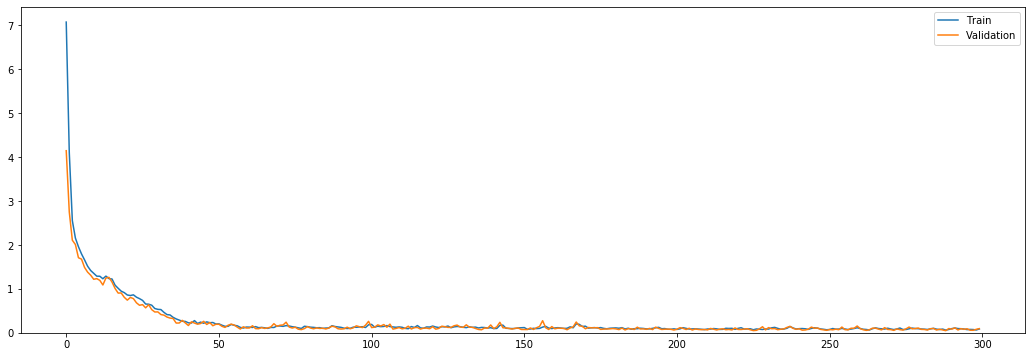

In [54]:
plot_loss(history)

In [55]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[-0.52282083,  0.46084997,  0.6364301 ,  0.68321276,  0.7931512 ,
         0.91513795,  0.969381  ,  1.3604157 ,  1.3047167 ],
       [-1.1545297 ,  0.8134768 ,  0.9801931 ,  1.3430848 ,  1.5174346 ,
         1.7105336 ,  1.7925899 ,  2.0654776 ,  2.3022878 ]],
      dtype=float32)

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [56]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [57]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [58]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [59]:
target_df.head()

,target
2011-01-29,0.751272
2011-01-30,1.175314
2011-01-31,1.527411
2011-02-01,0.952662
2011-02-02,0.595021


In [60]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [61]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [62]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [63]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

In [64]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [65]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 1575 samples, validate on 394 samples
Epoch 1/300
1575/1575 [==============================] - 4s 2ms/sample - loss: 4.2071 - q0_loss: 0.0099 - q1_loss: 0.0911 - q2_loss: 0.2464 - q3_loss: 0.1672 - q4_loss: 0.6883 - q5_loss: 0.6114 - q6_loss: 0.8452 - q7_loss: 1.0800 - q8_loss: 0.4631 - val_loss: 3.5987 - val_q0_loss: 0.0037 - val_q1_loss: 0.0147 - val_q2_loss: 0.0938 - val_q3_loss: 0.0862 - val_q4_loss: 0.7248 - val_q5_loss: 0.4696 - val_q6_loss: 0.8725 - val_q7_loss: 1.0189 - val_q8_loss: 0.2895
Epoch 2/300
1575/1575 [==============================] - 0s 127us/sample - loss: 3.2800 - q0_loss: 0.0034 - q1_loss: 0.0209 - q2_loss: 0.0850 - q3_loss: 0.0823 - q4_loss: 0.7526 - q5_loss: 0.3410 - q6_loss: 0.8824 - q7_loss: 0.9511 - q8_loss: 0.1613 - val_loss: 3.1080 - val_q0_loss: 0.0035 - val_q1_loss: 0.0174 - val_q2_loss: 0.0703 - val_q3_loss: 0.0693 - val_q4_loss: 0.7612 - val_q5_loss: 0.2655 - val_q6_loss: 0.8952 - val_q7_loss: 0.9008 - val_q8_loss: 0.1004
Epoch 3/300
1575/1575

1575/1575 [==============================] - 0s 122us/sample - loss: 0.3893 - q0_loss: 0.0026 - q1_loss: 0.0113 - q2_loss: 0.0447 - q3_loss: 0.0680 - q4_loss: 0.1322 - q5_loss: 0.0557 - q6_loss: 0.0560 - q7_loss: 0.0168 - q8_loss: 0.0042 - val_loss: 0.3871 - val_q0_loss: 0.0024 - val_q1_loss: 0.0100 - val_q2_loss: 0.0401 - val_q3_loss: 0.0594 - val_q4_loss: 0.1353 - val_q5_loss: 0.0542 - val_q6_loss: 0.0582 - val_q7_loss: 0.0171 - val_q8_loss: 0.0039
Epoch 19/300
1575/1575 [==============================] - 0s 116us/sample - loss: 0.3807 - q0_loss: 0.0024 - q1_loss: 0.0107 - q2_loss: 0.0441 - q3_loss: 0.0629 - q4_loss: 0.1293 - q5_loss: 0.0559 - q6_loss: 0.0542 - q7_loss: 0.0165 - q8_loss: 0.0043 - val_loss: 0.3773 - val_q0_loss: 0.0023 - val_q1_loss: 0.0095 - val_q2_loss: 0.0425 - val_q3_loss: 0.0586 - val_q4_loss: 0.1333 - val_q5_loss: 0.0572 - val_q6_loss: 0.0492 - val_q7_loss: 0.0159 - val_q8_loss: 0.0043
Epoch 20/300
1575/1575 [==============================] - 0s 113us/sample - l

Epoch 36/300
1575/1575 [==============================] - 0s 116us/sample - loss: 0.3118 - q0_loss: 0.0028 - q1_loss: 0.0104 - q2_loss: 0.0444 - q3_loss: 0.0572 - q4_loss: 0.0777 - q5_loss: 0.0554 - q6_loss: 0.0468 - q7_loss: 0.0127 - q8_loss: 0.0045 - val_loss: 0.3164 - val_q0_loss: 0.0029 - val_q1_loss: 0.0097 - val_q2_loss: 0.0417 - val_q3_loss: 0.0563 - val_q4_loss: 0.0746 - val_q5_loss: 0.0561 - val_q6_loss: 0.0528 - val_q7_loss: 0.0139 - val_q8_loss: 0.0038
Epoch 37/300
1575/1575 [==============================] - 0s 114us/sample - loss: 0.3029 - q0_loss: 0.0027 - q1_loss: 0.0101 - q2_loss: 0.0431 - q3_loss: 0.0558 - q4_loss: 0.0761 - q5_loss: 0.0545 - q6_loss: 0.0440 - q7_loss: 0.0129 - q8_loss: 0.0041 - val_loss: 0.3081 - val_q0_loss: 0.0023 - val_q1_loss: 0.0094 - val_q2_loss: 0.0417 - val_q3_loss: 0.0523 - val_q4_loss: 0.0774 - val_q5_loss: 0.0542 - val_q6_loss: 0.0490 - val_q7_loss: 0.0139 - val_q8_loss: 0.0047
Epoch 38/300
1575/1575 [==============================] - 0s 116

1575/1575 [==============================] - 0s 120us/sample - loss: 0.3001 - q0_loss: 0.0025 - q1_loss: 0.0097 - q2_loss: 0.0432 - q3_loss: 0.0550 - q4_loss: 0.0705 - q5_loss: 0.0574 - q6_loss: 0.0448 - q7_loss: 0.0126 - q8_loss: 0.0047 - val_loss: 0.3488 - val_q0_loss: 0.0027 - val_q1_loss: 0.0101 - val_q2_loss: 0.0450 - val_q3_loss: 0.0608 - val_q4_loss: 0.0777 - val_q5_loss: 0.0643 - val_q6_loss: 0.0595 - val_q7_loss: 0.0119 - val_q8_loss: 0.0141
Epoch 54/300
1575/1575 [==============================] - 0s 117us/sample - loss: 0.2969 - q0_loss: 0.0026 - q1_loss: 0.0097 - q2_loss: 0.0440 - q3_loss: 0.0547 - q4_loss: 0.0695 - q5_loss: 0.0560 - q6_loss: 0.0443 - q7_loss: 0.0121 - q8_loss: 0.0043 - val_loss: 0.2985 - val_q0_loss: 0.0026 - val_q1_loss: 0.0089 - val_q2_loss: 0.0406 - val_q3_loss: 0.0516 - val_q4_loss: 0.0684 - val_q5_loss: 0.0549 - val_q6_loss: 0.0492 - val_q7_loss: 0.0131 - val_q8_loss: 0.0040
Epoch 55/300
1575/1575 [==============================] - 0s 116us/sample - l

Epoch 71/300
1575/1575 [==============================] - 0s 117us/sample - loss: 0.2964 - q0_loss: 0.0024 - q1_loss: 0.0098 - q2_loss: 0.0436 - q3_loss: 0.0553 - q4_loss: 0.0704 - q5_loss: 0.0574 - q6_loss: 0.0464 - q7_loss: 0.0112 - q8_loss: 0.0052 - val_loss: 0.2907 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0423 - val_q3_loss: 0.0522 - val_q4_loss: 0.0655 - val_q5_loss: 0.0563 - val_q6_loss: 0.0443 - val_q7_loss: 0.0114 - val_q8_loss: 0.0039
Epoch 72/300
1575/1575 [==============================] - 0s 117us/sample - loss: 0.2989 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0440 - q3_loss: 0.0550 - q4_loss: 0.0706 - q5_loss: 0.0563 - q6_loss: 0.0460 - q7_loss: 0.0112 - q8_loss: 0.0044 - val_loss: 0.2862 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0396 - val_q3_loss: 0.0511 - val_q4_loss: 0.0651 - val_q5_loss: 0.0556 - val_q6_loss: 0.0434 - val_q7_loss: 0.0119 - val_q8_loss: 0.0041
Epoch 73/300
1575/1575 [==============================] - 0s 116

1575/1575 [==============================] - 0s 115us/sample - loss: 0.2868 - q0_loss: 0.0023 - q1_loss: 0.0097 - q2_loss: 0.0423 - q3_loss: 0.0528 - q4_loss: 0.0671 - q5_loss: 0.0535 - q6_loss: 0.0432 - q7_loss: 0.0101 - q8_loss: 0.0042 - val_loss: 0.2904 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0411 - val_q3_loss: 0.0521 - val_q4_loss: 0.0664 - val_q5_loss: 0.0555 - val_q6_loss: 0.0452 - val_q7_loss: 0.0111 - val_q8_loss: 0.0040
Epoch 89/300
1575/1575 [==============================] - 0s 113us/sample - loss: 0.2906 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0430 - q3_loss: 0.0539 - q4_loss: 0.0685 - q5_loss: 0.0545 - q6_loss: 0.0447 - q7_loss: 0.0104 - q8_loss: 0.0041 - val_loss: 0.2879 - val_q0_loss: 0.0022 - val_q1_loss: 0.0089 - val_q2_loss: 0.0413 - val_q3_loss: 0.0519 - val_q4_loss: 0.0657 - val_q5_loss: 0.0556 - val_q6_loss: 0.0437 - val_q7_loss: 0.0113 - val_q8_loss: 0.0042
Epoch 90/300
1575/1575 [==============================] - 0s 115us/sample - l

Epoch 106/300
1575/1575 [==============================] - 0s 153us/sample - loss: 0.2859 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0419 - q3_loss: 0.0528 - q4_loss: 0.0669 - q5_loss: 0.0536 - q6_loss: 0.0430 - q7_loss: 0.0101 - q8_loss: 0.0039 - val_loss: 0.2842 - val_q0_loss: 0.0022 - val_q1_loss: 0.0090 - val_q2_loss: 0.0405 - val_q3_loss: 0.0510 - val_q4_loss: 0.0651 - val_q5_loss: 0.0552 - val_q6_loss: 0.0430 - val_q7_loss: 0.0107 - val_q8_loss: 0.0038
Epoch 107/300
1575/1575 [==============================] - 0s 189us/sample - loss: 0.2844 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0414 - q3_loss: 0.0528 - q4_loss: 0.0669 - q5_loss: 0.0530 - q6_loss: 0.0426 - q7_loss: 0.0101 - q8_loss: 0.0038 - val_loss: 0.2973 - val_q0_loss: 0.0024 - val_q1_loss: 0.0090 - val_q2_loss: 0.0403 - val_q3_loss: 0.0530 - val_q4_loss: 0.0676 - val_q5_loss: 0.0569 - val_q6_loss: 0.0471 - val_q7_loss: 0.0116 - val_q8_loss: 0.0044
Epoch 108/300
1575/1575 [==============================] - 0s 

1575/1575 [==============================] - 0s 114us/sample - loss: 0.2889 - q0_loss: 0.0023 - q1_loss: 0.0097 - q2_loss: 0.0433 - q3_loss: 0.0538 - q4_loss: 0.0679 - q5_loss: 0.0549 - q6_loss: 0.0419 - q7_loss: 0.0102 - q8_loss: 0.0034 - val_loss: 0.2855 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0406 - val_q3_loss: 0.0517 - val_q4_loss: 0.0659 - val_q5_loss: 0.0552 - val_q6_loss: 0.0433 - val_q7_loss: 0.0109 - val_q8_loss: 0.0031
Epoch 124/300
1575/1575 [==============================] - 0s 110us/sample - loss: 0.2847 - q0_loss: 0.0023 - q1_loss: 0.0096 - q2_loss: 0.0422 - q3_loss: 0.0534 - q4_loss: 0.0675 - q5_loss: 0.0535 - q6_loss: 0.0430 - q7_loss: 0.0100 - q8_loss: 0.0034 - val_loss: 0.2864 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0408 - val_q3_loss: 0.0514 - val_q4_loss: 0.0657 - val_q5_loss: 0.0550 - val_q6_loss: 0.0428 - val_q7_loss: 0.0111 - val_q8_loss: 0.0035
Epoch 125/300
1575/1575 [==============================] - 0s 115us/sample -

1575/1575 [==============================] - 0s 113us/sample - loss: 0.2850 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0415 - q3_loss: 0.0533 - q4_loss: 0.0673 - q5_loss: 0.0543 - q6_loss: 0.0425 - q7_loss: 0.0102 - q8_loss: 0.0032 - val_loss: 0.2896 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0422 - val_q3_loss: 0.0526 - val_q4_loss: 0.0660 - val_q5_loss: 0.0555 - val_q6_loss: 0.0445 - val_q7_loss: 0.0110 - val_q8_loss: 0.0028
Epoch 141/300
1575/1575 [==============================] - 0s 121us/sample - loss: 0.2845 - q0_loss: 0.0024 - q1_loss: 0.0096 - q2_loss: 0.0423 - q3_loss: 0.0536 - q4_loss: 0.0683 - q5_loss: 0.0543 - q6_loss: 0.0435 - q7_loss: 0.0102 - q8_loss: 0.0032 - val_loss: 0.2947 - val_q0_loss: 0.0023 - val_q1_loss: 0.0098 - val_q2_loss: 0.0445 - val_q3_loss: 0.0523 - val_q4_loss: 0.0661 - val_q5_loss: 0.0575 - val_q6_loss: 0.0430 - val_q7_loss: 0.0117 - val_q8_loss: 0.0029
Epoch 142/300
1575/1575 [==============================] - 0s 114us/sample -

1575/1575 [==============================] - 0s 138us/sample - loss: 0.2840 - q0_loss: 0.0024 - q1_loss: 0.0095 - q2_loss: 0.0421 - q3_loss: 0.0526 - q4_loss: 0.0670 - q5_loss: 0.0541 - q6_loss: 0.0424 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2945 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0404 - val_q3_loss: 0.0525 - val_q4_loss: 0.0680 - val_q5_loss: 0.0574 - val_q6_loss: 0.0474 - val_q7_loss: 0.0113 - val_q8_loss: 0.0031
Epoch 158/300
1575/1575 [==============================] - 0s 129us/sample - loss: 0.2844 - q0_loss: 0.0023 - q1_loss: 0.0096 - q2_loss: 0.0421 - q3_loss: 0.0531 - q4_loss: 0.0673 - q5_loss: 0.0536 - q6_loss: 0.0419 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2879 - val_q0_loss: 0.0022 - val_q1_loss: 0.0093 - val_q2_loss: 0.0419 - val_q3_loss: 0.0520 - val_q4_loss: 0.0653 - val_q5_loss: 0.0552 - val_q6_loss: 0.0444 - val_q7_loss: 0.0113 - val_q8_loss: 0.0025
Epoch 159/300
1575/1575 [==============================] - 0s 127us/sample -

1575/1575 [==============================] - 0s 127us/sample - loss: 0.2829 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0421 - q3_loss: 0.0531 - q4_loss: 0.0669 - q5_loss: 0.0540 - q6_loss: 0.0418 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2882 - val_q0_loss: 0.0022 - val_q1_loss: 0.0095 - val_q2_loss: 0.0430 - val_q3_loss: 0.0521 - val_q4_loss: 0.0650 - val_q5_loss: 0.0553 - val_q6_loss: 0.0443 - val_q7_loss: 0.0111 - val_q8_loss: 0.0026
Epoch 175/300
1575/1575 [==============================] - 0s 150us/sample - loss: 0.2839 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0427 - q3_loss: 0.0529 - q4_loss: 0.0665 - q5_loss: 0.0541 - q6_loss: 0.0418 - q7_loss: 0.0104 - q8_loss: 0.0025 - val_loss: 0.3049 - val_q0_loss: 0.0022 - val_q1_loss: 0.0096 - val_q2_loss: 0.0451 - val_q3_loss: 0.0552 - val_q4_loss: 0.0693 - val_q5_loss: 0.0613 - val_q6_loss: 0.0444 - val_q7_loss: 0.0118 - val_q8_loss: 0.0028
Epoch 176/300
1575/1575 [==============================] - 0s 156us/sample -

1575/1575 [==============================] - 0s 138us/sample - loss: 0.2826 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0421 - q3_loss: 0.0533 - q4_loss: 0.0670 - q5_loss: 0.0543 - q6_loss: 0.0424 - q7_loss: 0.0103 - q8_loss: 0.0025 - val_loss: 0.3007 - val_q0_loss: 0.0023 - val_q1_loss: 0.0093 - val_q2_loss: 0.0421 - val_q3_loss: 0.0535 - val_q4_loss: 0.0681 - val_q5_loss: 0.0582 - val_q6_loss: 0.0477 - val_q7_loss: 0.0127 - val_q8_loss: 0.0032
Epoch 192/300
1575/1575 [==============================] - ETA: 0s - loss: 0.2773 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0409 - q3_loss: 0.0525 - q4_loss: 0.0660 - q5_loss: 0.0525 - q6_loss: 0.0414 - q7_loss: 0.0098 - q8_loss: 0.002 - 0s 123us/sample - loss: 0.2817 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0413 - q3_loss: 0.0532 - q4_loss: 0.0677 - q5_loss: 0.0545 - q6_loss: 0.0430 - q7_loss: 0.0104 - q8_loss: 0.0026 - val_loss: 0.2861 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0399 - val_q3_loss: 0.0519 

1575/1575 [==============================] - 0s 119us/sample - loss: 0.2812 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0414 - q3_loss: 0.0529 - q4_loss: 0.0667 - q5_loss: 0.0536 - q6_loss: 0.0417 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.3015 - val_q0_loss: 0.0023 - val_q1_loss: 0.0097 - val_q2_loss: 0.0439 - val_q3_loss: 0.0535 - val_q4_loss: 0.0677 - val_q5_loss: 0.0586 - val_q6_loss: 0.0453 - val_q7_loss: 0.0129 - val_q8_loss: 0.0032
Epoch 209/300
1575/1575 [==============================] - 0s 118us/sample - loss: 0.2818 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0418 - q3_loss: 0.0533 - q4_loss: 0.0668 - q5_loss: 0.0533 - q6_loss: 0.0418 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2850 - val_q0_loss: 0.0022 - val_q1_loss: 0.0091 - val_q2_loss: 0.0409 - val_q3_loss: 0.0515 - val_q4_loss: 0.0650 - val_q5_loss: 0.0554 - val_q6_loss: 0.0442 - val_q7_loss: 0.0109 - val_q8_loss: 0.0025
Epoch 210/300
1575/1575 [==============================] - 0s 130us/sample -

1575/1575 [==============================] - 0s 115us/sample - loss: 0.2819 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0423 - q3_loss: 0.0535 - q4_loss: 0.0673 - q5_loss: 0.0537 - q6_loss: 0.0416 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2834 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0396 - val_q3_loss: 0.0512 - val_q4_loss: 0.0651 - val_q5_loss: 0.0550 - val_q6_loss: 0.0437 - val_q7_loss: 0.0109 - val_q8_loss: 0.0026
Epoch 226/300
1575/1575 [==============================] - 0s 116us/sample - loss: 0.2832 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0420 - q3_loss: 0.0535 - q4_loss: 0.0669 - q5_loss: 0.0542 - q6_loss: 0.0420 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2880 - val_q0_loss: 0.0022 - val_q1_loss: 0.0093 - val_q2_loss: 0.0422 - val_q3_loss: 0.0519 - val_q4_loss: 0.0653 - val_q5_loss: 0.0557 - val_q6_loss: 0.0450 - val_q7_loss: 0.0111 - val_q8_loss: 0.0024
Epoch 227/300
1575/1575 [==============================] - 0s 119us/sample -

1575/1575 [==============================] - 0s 117us/sample - loss: 0.2815 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0424 - q3_loss: 0.0533 - q4_loss: 0.0665 - q5_loss: 0.0537 - q6_loss: 0.0413 - q7_loss: 0.0098 - q8_loss: 0.0024 - val_loss: 0.2844 - val_q0_loss: 0.0023 - val_q1_loss: 0.0089 - val_q2_loss: 0.0399 - val_q3_loss: 0.0515 - val_q4_loss: 0.0652 - val_q5_loss: 0.0554 - val_q6_loss: 0.0447 - val_q7_loss: 0.0108 - val_q8_loss: 0.0025
Epoch 243/300
1575/1575 [==============================] - 0s 116us/sample - loss: 0.2813 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0415 - q3_loss: 0.0534 - q4_loss: 0.0678 - q5_loss: 0.0542 - q6_loss: 0.0423 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2886 - val_q0_loss: 0.0022 - val_q1_loss: 0.0096 - val_q2_loss: 0.0429 - val_q3_loss: 0.0521 - val_q4_loss: 0.0649 - val_q5_loss: 0.0549 - val_q6_loss: 0.0445 - val_q7_loss: 0.0112 - val_q8_loss: 0.0026
Epoch 244/300
1575/1575 [==============================] - 0s 117us/sample -

1575/1575 [==============================] - 0s 114us/sample - loss: 0.2804 - q0_loss: 0.0023 - q1_loss: 0.0094 - q2_loss: 0.0419 - q3_loss: 0.0538 - q4_loss: 0.0673 - q5_loss: 0.0532 - q6_loss: 0.0419 - q7_loss: 0.0099 - q8_loss: 0.0024 - val_loss: 0.2821 - val_q0_loss: 0.0023 - val_q1_loss: 0.0089 - val_q2_loss: 0.0400 - val_q3_loss: 0.0514 - val_q4_loss: 0.0651 - val_q5_loss: 0.0542 - val_q6_loss: 0.0433 - val_q7_loss: 0.0108 - val_q8_loss: 0.0026
Epoch 260/300
1575/1575 [==============================] - 0s 114us/sample - loss: 0.2816 - q0_loss: 0.0023 - q1_loss: 0.0095 - q2_loss: 0.0413 - q3_loss: 0.0530 - q4_loss: 0.0675 - q5_loss: 0.0536 - q6_loss: 0.0423 - q7_loss: 0.0101 - q8_loss: 0.0026 - val_loss: 0.2830 - val_q0_loss: 0.0023 - val_q1_loss: 0.0090 - val_q2_loss: 0.0402 - val_q3_loss: 0.0513 - val_q4_loss: 0.0649 - val_q5_loss: 0.0549 - val_q6_loss: 0.0434 - val_q7_loss: 0.0110 - val_q8_loss: 0.0025
Epoch 261/300
1575/1575 [==============================] - 0s 116us/sample -

1575/1575 [==============================] - 0s 128us/sample - loss: 0.2829 - q0_loss: 0.0024 - q1_loss: 0.0094 - q2_loss: 0.0414 - q3_loss: 0.0534 - q4_loss: 0.0677 - q5_loss: 0.0537 - q6_loss: 0.0419 - q7_loss: 0.0101 - q8_loss: 0.0025 - val_loss: 0.2863 - val_q0_loss: 0.0022 - val_q1_loss: 0.0093 - val_q2_loss: 0.0416 - val_q3_loss: 0.0518 - val_q4_loss: 0.0657 - val_q5_loss: 0.0546 - val_q6_loss: 0.0432 - val_q7_loss: 0.0112 - val_q8_loss: 0.0027
Epoch 277/300
1575/1575 [==============================] - 0s 130us/sample - loss: 0.2821 - q0_loss: 0.0023 - q1_loss: 0.0092 - q2_loss: 0.0416 - q3_loss: 0.0530 - q4_loss: 0.0668 - q5_loss: 0.0536 - q6_loss: 0.0417 - q7_loss: 0.0101 - q8_loss: 0.0024 - val_loss: 0.2854 - val_q0_loss: 0.0021 - val_q1_loss: 0.0089 - val_q2_loss: 0.0396 - val_q3_loss: 0.0519 - val_q4_loss: 0.0666 - val_q5_loss: 0.0557 - val_q6_loss: 0.0437 - val_q7_loss: 0.0109 - val_q8_loss: 0.0026
Epoch 278/300
1575/1575 [==============================] - 0s 119us/sample -

1575/1575 [==============================] - 0s 119us/sample - loss: 0.2807 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0416 - q3_loss: 0.0532 - q4_loss: 0.0669 - q5_loss: 0.0536 - q6_loss: 0.0416 - q7_loss: 0.0100 - q8_loss: 0.0025 - val_loss: 0.2867 - val_q0_loss: 0.0023 - val_q1_loss: 0.0091 - val_q2_loss: 0.0410 - val_q3_loss: 0.0517 - val_q4_loss: 0.0655 - val_q5_loss: 0.0559 - val_q6_loss: 0.0444 - val_q7_loss: 0.0109 - val_q8_loss: 0.0025
Epoch 294/300
1575/1575 [==============================] - 0s 120us/sample - loss: 0.2806 - q0_loss: 0.0023 - q1_loss: 0.0093 - q2_loss: 0.0413 - q3_loss: 0.0527 - q4_loss: 0.0667 - q5_loss: 0.0537 - q6_loss: 0.0415 - q7_loss: 0.0099 - q8_loss: 0.0025 - val_loss: 0.2838 - val_q0_loss: 0.0022 - val_q1_loss: 0.0092 - val_q2_loss: 0.0406 - val_q3_loss: 0.0515 - val_q4_loss: 0.0651 - val_q5_loss: 0.0542 - val_q6_loss: 0.0440 - val_q7_loss: 0.0110 - val_q8_loss: 0.0027
Epoch 295/300
1575/1575 [==============================] - 0s 127us/sample -

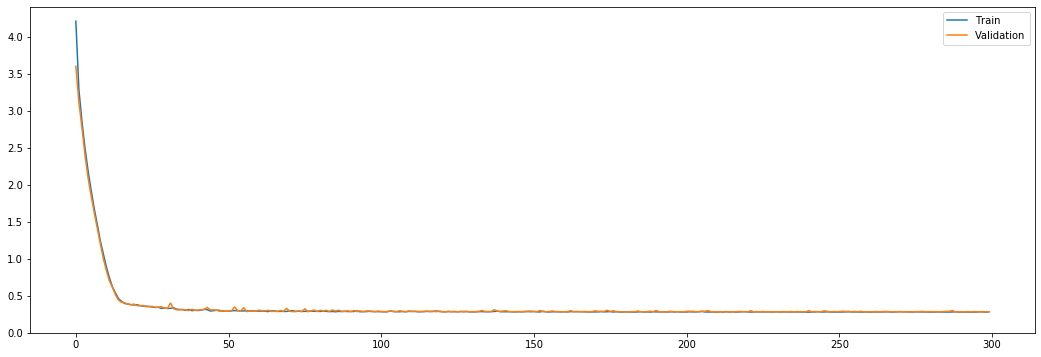

In [66]:
plot_loss(history)

### Predicted distribution

In [67]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.41041088, 0.49317554, 0.6114328 , 0.6527271 , 0.7440677 ,
        0.8256191 , 0.85717916, 1.0110995 , 1.0857059 ],
       [0.8364941 , 0.93872774, 1.1946579 , 1.2441773 , 1.4037459 ,
        1.5955403 , 1.6302515 , 1.9330577 , 2.0788462 ]], dtype=float32)

In [68]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

0.005    0.415018
0.025    0.497439
0.165    0.623131
0.250    0.662261
0.500    0.750136
0.750    0.837875
0.835    0.876631
0.975    1.004837
0.995    1.083839
dtype: float64

In [69]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

0.005    0.855376
0.025    1.009875
0.165    1.257012
0.250    1.330647
0.500    1.500027
0.750    1.669428
0.835    1.742808
0.975    1.988162
0.995    2.141759
dtype: float64

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!